# NR Sanity check
* Load NR simulation
* Compare raw coprecessing frame data (no symmetrisation) with calibration data and models

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
#
from positive import *
from matplotlib.pyplot import *
#
from numpy import *
from numpy.fft import ifft,fftshift,fftfreq,fft
from glob import glob as find
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
from nrutils.core.basics import *
from nrutils import scsearch,gwylm
#
from lalsimulation import SimInspiralChooseFDWaveform
import lalsimulation as lalsim
#
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


In [2]:
#
datadir = '/Users/book/KOALA/PhenomXCP/data/version4/'
data_path = datadir+'calibration_data_dict.pickle'
calibration_data_dict = pickle.load( open( data_path, "rb" ) )

In [77]:
#
# bam_id = 'q4a06t90'
# bam_id = 'q8a08t120'
# bam_id = 'q8a08t90'
bam_id = 'q2a06t150'
a = scsearch(keyword=bam_id,verbose=True,catalog=calibration_catalog)[-1]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q2a06t150) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 1 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q2: 1chi0.60-p-q2.00	(q2a06t150dP0_T_96_408)



In [78]:
# Get metadata for case. The spins here are in the "LAL" frame
# ---

#
k = [ k for k,simname in enumerate(metadata_dict['simname']) if simname in a.simname ][0]

# Collect params for this case 
theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z,Mf,Xf = metadata_dict['array_data'][k,:]

# chi1_vec = array([chi1_y,chi1_x,chi1_z])
# chi2_vec = array([chi2_y,chi2_x,chi2_z])

chi1_vec = array([chi1_x,chi1_y,chi1_z])
chi2_vec = array([chi2_x,chi2_y,chi2_z])

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* #
# Load data that has been processed in issue 3c
# ---
ll = mm = 3
(metadata,f,dphi_fd,amp_fd,xphm_dphi,dphi_fd_enforced_min,nr_dphi_lm_shift,min_xphm_dphi_l2m2) = calibration_data_dict[ll,mm][a.simname]
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* #



In [79]:
#
y = gwylm(a,lmax=4,clean=True,verbose=False,dt=0.5,pad=1000)

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.


In [80]:

#
kind='psi4'

#
frame = {}
frame['raw'] = y

#
frame['init-j'] = y.__calc_initial_j_frame__()
frame['init-l'] = y.__calc_initial_l_frame__()

#
frame['psi4-td-cp'] = frame['init-j'].__calc_coprecessing_frame__(kind='psi4',transform_domain='td',verbose=True)
frame['psi4-fd-cp'] = frame['init-j'].__calc_coprecessing_frame__(kind='psi4',transform_domain='fd',verbose=True)

#
frame['psi4-fd-l3-cp'] = frame['init-j'].selectlm( [(ll,m_) for m_ in range(-ll,ll+1)] ).__calc_coprecessing_frame__( kind=kind,transform_domain='fd' )
frame['psi4-td-l3-cp'] = frame['init-j'].selectlm( [(ll,m_) for m_ in range(-ll,ll+1)] ).__calc_coprecessing_frame__( kind=kind,transform_domain='td' )


(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__calc_coprecessing_frame__)>> We will use psi4 to compute the co-precessing frame.
(__calc_coprecessing_frame__)>> Transforming to the coprecessing frame using TD angles.
(calc_coprecessing_angles)>> The domain values seem unevenly split between 

In [81]:

#
lmlist = [(ll,ll)]
opts = ['1-pnr','4-xhm','2-xphm']

#
for opt in opts:
    
    #
    phenom_moments_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=opt )

    #
    h = phenom_moments_dict[(ll,ll)]

    #
    amp = abs(h)
    phi = unwrap( angle(h) )
    dphi_raw = spline_diff( f, phi )
    dphi = dphi_raw - mean(dphi_raw)


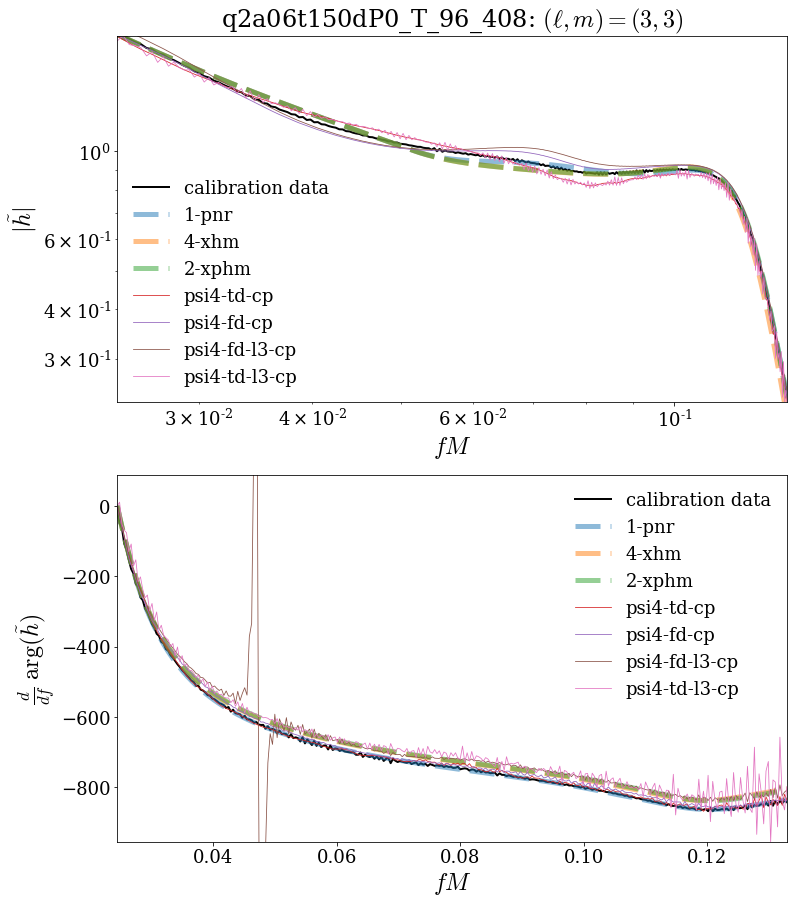

In [83]:

#
lmlist = [(ll,ll)]
opts = ['1-pnr','4-xhm','2-xphm']

#
# center = lambda x: x -  mean(x)
center = lambda x: x - x[0]

#
# use_negative_emm_nr = True
use_negative_emm_nr = False

#
fmin_plotting = min(f) #frame['raw'].wstart*ll/(2*pi)
fmax_plotting = max(f) #0.1*ll/2

#
fig,ax = subplots( 2,1 , figsize=3*figaspect(0.618*2) )
ax = ax.flatten()

#
sca(ax[0])
domain = f
mask = (f>=fmin_plotting) & (f<=fmax_plotting)
codomain = amp_fd
plot( domain, codomain, color='k', lw=2, alpha=0.99, ls='-', label='calibration data' )

#
sca(ax[1])
domain = f
mask = (f>=fmin_plotting) & (f<=fmax_plotting)
codomain = center(dphi_fd[mask])
plot( domain, codomain, color='k', lw=2, alpha=0.99, ls='-', label='calibration data' )
ylim( limy(domain, codomain, dilate=0.1) )

#
for opt in opts:
    
    #
    phenom_moments_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=opt )

    #
    h = phenom_moments_dict[(ll,ll)]

    #
    amp = abs(h)
    phi = unwrap( angle(h) )
    dphi_raw = spline_diff( f, phi )
    dphi = dphi_raw - mean(dphi_raw)
    
    #
    sca( ax[0] )
    # ---
    domain   = f
    codomain = amp
    plot( domain, codomain, label=opt, lw=5, alpha=0.5, ls='--' )
    
    #
    sca( ax[1] )
    # ---
    domain   = f
    codomain = center(dphi)
    plot( domain, codomain, label=opt, lw=5, alpha=0.5, ls='--' )


#
key_list = ['psi4-td-cp','psi4-fd-cp','psi4-fd-l3-cp','psi4-td-l3-cp']

#
for k in key_list:

    #
    sca( ax[0] )
    # ---
    yy = frame[k]
    mask = (yy.f>=fmin_plotting) & (yy.f<=fmax_plotting)
    if use_negative_emm_nr: mask = (-yy.f>=fmin_plotting) & (-yy.f<=fmax_plotting)
    domain   = -yy.f[mask] if use_negative_emm_nr else yy.f[mask]
    codomain = yy[ll,ll*(-1 if use_negative_emm_nr else 1)]['strain'].fd_amp[mask]
    plot( domain, codomain, label=k )

    #
    xlim( fmin_plotting, fmax_plotting )
    yscale('log')
    xscale('log')
    ylim( limy(domain, codomain) )
    #
    ylabel(r'$|\tilde{h}|$')

    #
    sca( ax[1] )
    # ---
    yy = frame[k]
    domain   = -yy.f[mask][::-1] if use_negative_emm_nr else yy.f[mask]
    codomain = yy[ll,ll*(-1 if use_negative_emm_nr else 1)]['strain'].fd_dphi[mask]
    codomain = center( codomain[::-1] if use_negative_emm_nr else codomain )
    plot( domain, codomain, label=k )

    #
    xlim( fmin_plotting, max(f) )
    #ylim( limy(domain, codomain) )
    #
    ylabel(r'$\frac{d}{df} \; \arg(\tilde{h})$')
    
#
for ax_ in ax:
    sca(ax_)
    legend()
    xlabel('$fM$')
    
#
sca(ax[0])
title( y.simname+': $(\ell,m)=(%i,%i)$'%(ll,-ll if use_negative_emm_nr else ll) )

#
savefig('/Users/book/KOALA/PhenomXCP/gallery/10_nr_sanity_checks/%s_%s.png'%(y.simname,'pos_emm' if not use_negative_emm_nr else 'neg_emm'))
